# Import Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_diabetes
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit



# PyTorch libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset

In [2]:
diabetes_data = load_diabetes()
df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)

# Add the target column to the DataFrame
df['progression'] = diabetes_data.target

# Save the DataFrame to a CSV file
df.to_csv('diabetes_data.csv', index=False)


df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


# Step 1 : Prep the data

- Load for Missing , Null, NAN Values

- Find Outliers

- Transform the data such that all entries should be numeric

In [3]:
# Check for missing values
print(df.isnull().sum())

# Check for NaN values
print(df.isna().sum())


age            0
sex            0
bmi            0
bp             0
s1             0
s2             0
s3             0
s4             0
s5             0
s6             0
progression    0
dtype: int64
age            0
sex            0
bmi            0
bp             0
s1             0
s2             0
s3             0
s4             0
s5             0
s6             0
progression    0
dtype: int64


We would have them we would handle them in the following manner:

- Check for missing values
print(df.isnull().sum())

- Check for NaN values
print(df.isna().sum())

- Filling missing values with mean
df.fillna(df.mean(), inplace=True)

- Alternatively, to drop rows with any NaN values
df.dropna(inplace=True)


- FInd Outliers

In [4]:
# Look for outliers using the Interquartile Range (IQR) method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define an outlier as being beyond 1.5 times the IQR from the Q1 or Q3
# This is a common rule of thumb for identifying outliers
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"\nNumber of rows with outliers: {outliers.sum()}")


Number of rows with outliers: 31


- Convert all data to Numeric

In [5]:

for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')




# Step 2: List all the data types as numeric, categorical etc.

- List all types of data

In [6]:
# List all the columns and their data types
print(df.dtypes)

# Programmatically separate numeric and categorical columns based on dtype
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
categorical_columns = df.select_dtypes(exclude=['number', 'bool']).columns.tolist()


for col in numeric_columns:
    if df[col].nunique() < 10:  # nunique() returns the number of unique values
        numeric_columns.remove(col)
        categorical_columns.append(col)

print("Numeric columns:", numeric_columns)
print("Categorical columns:", categorical_columns)


age            float64
sex            float64
bmi            float64
bp             float64
s1             float64
s2             float64
s3             float64
s4             float64
s5             float64
s6             float64
progression    float64
dtype: object
Numeric columns: ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
Categorical columns: ['sex']


# Step3: Perform EDA

### We first Perform the plotting using standard pandas and matplotlib

We will use the following plots 

- Pairplots: To visualize the distributions and relationships

- Correlation Matrix Heatmap:A graphical representation of the correlation coefficients between every pair of variables in the data, providing a quick visual summary of how each variable is related to the others.

- Histograms: To visualize the distributions of each feature

- Box plots: To check for outliers in each feature

- Scatter plots: Plot these with the target variable to visualize individual relationships


Pairplot showing the distributions and relationships between features:


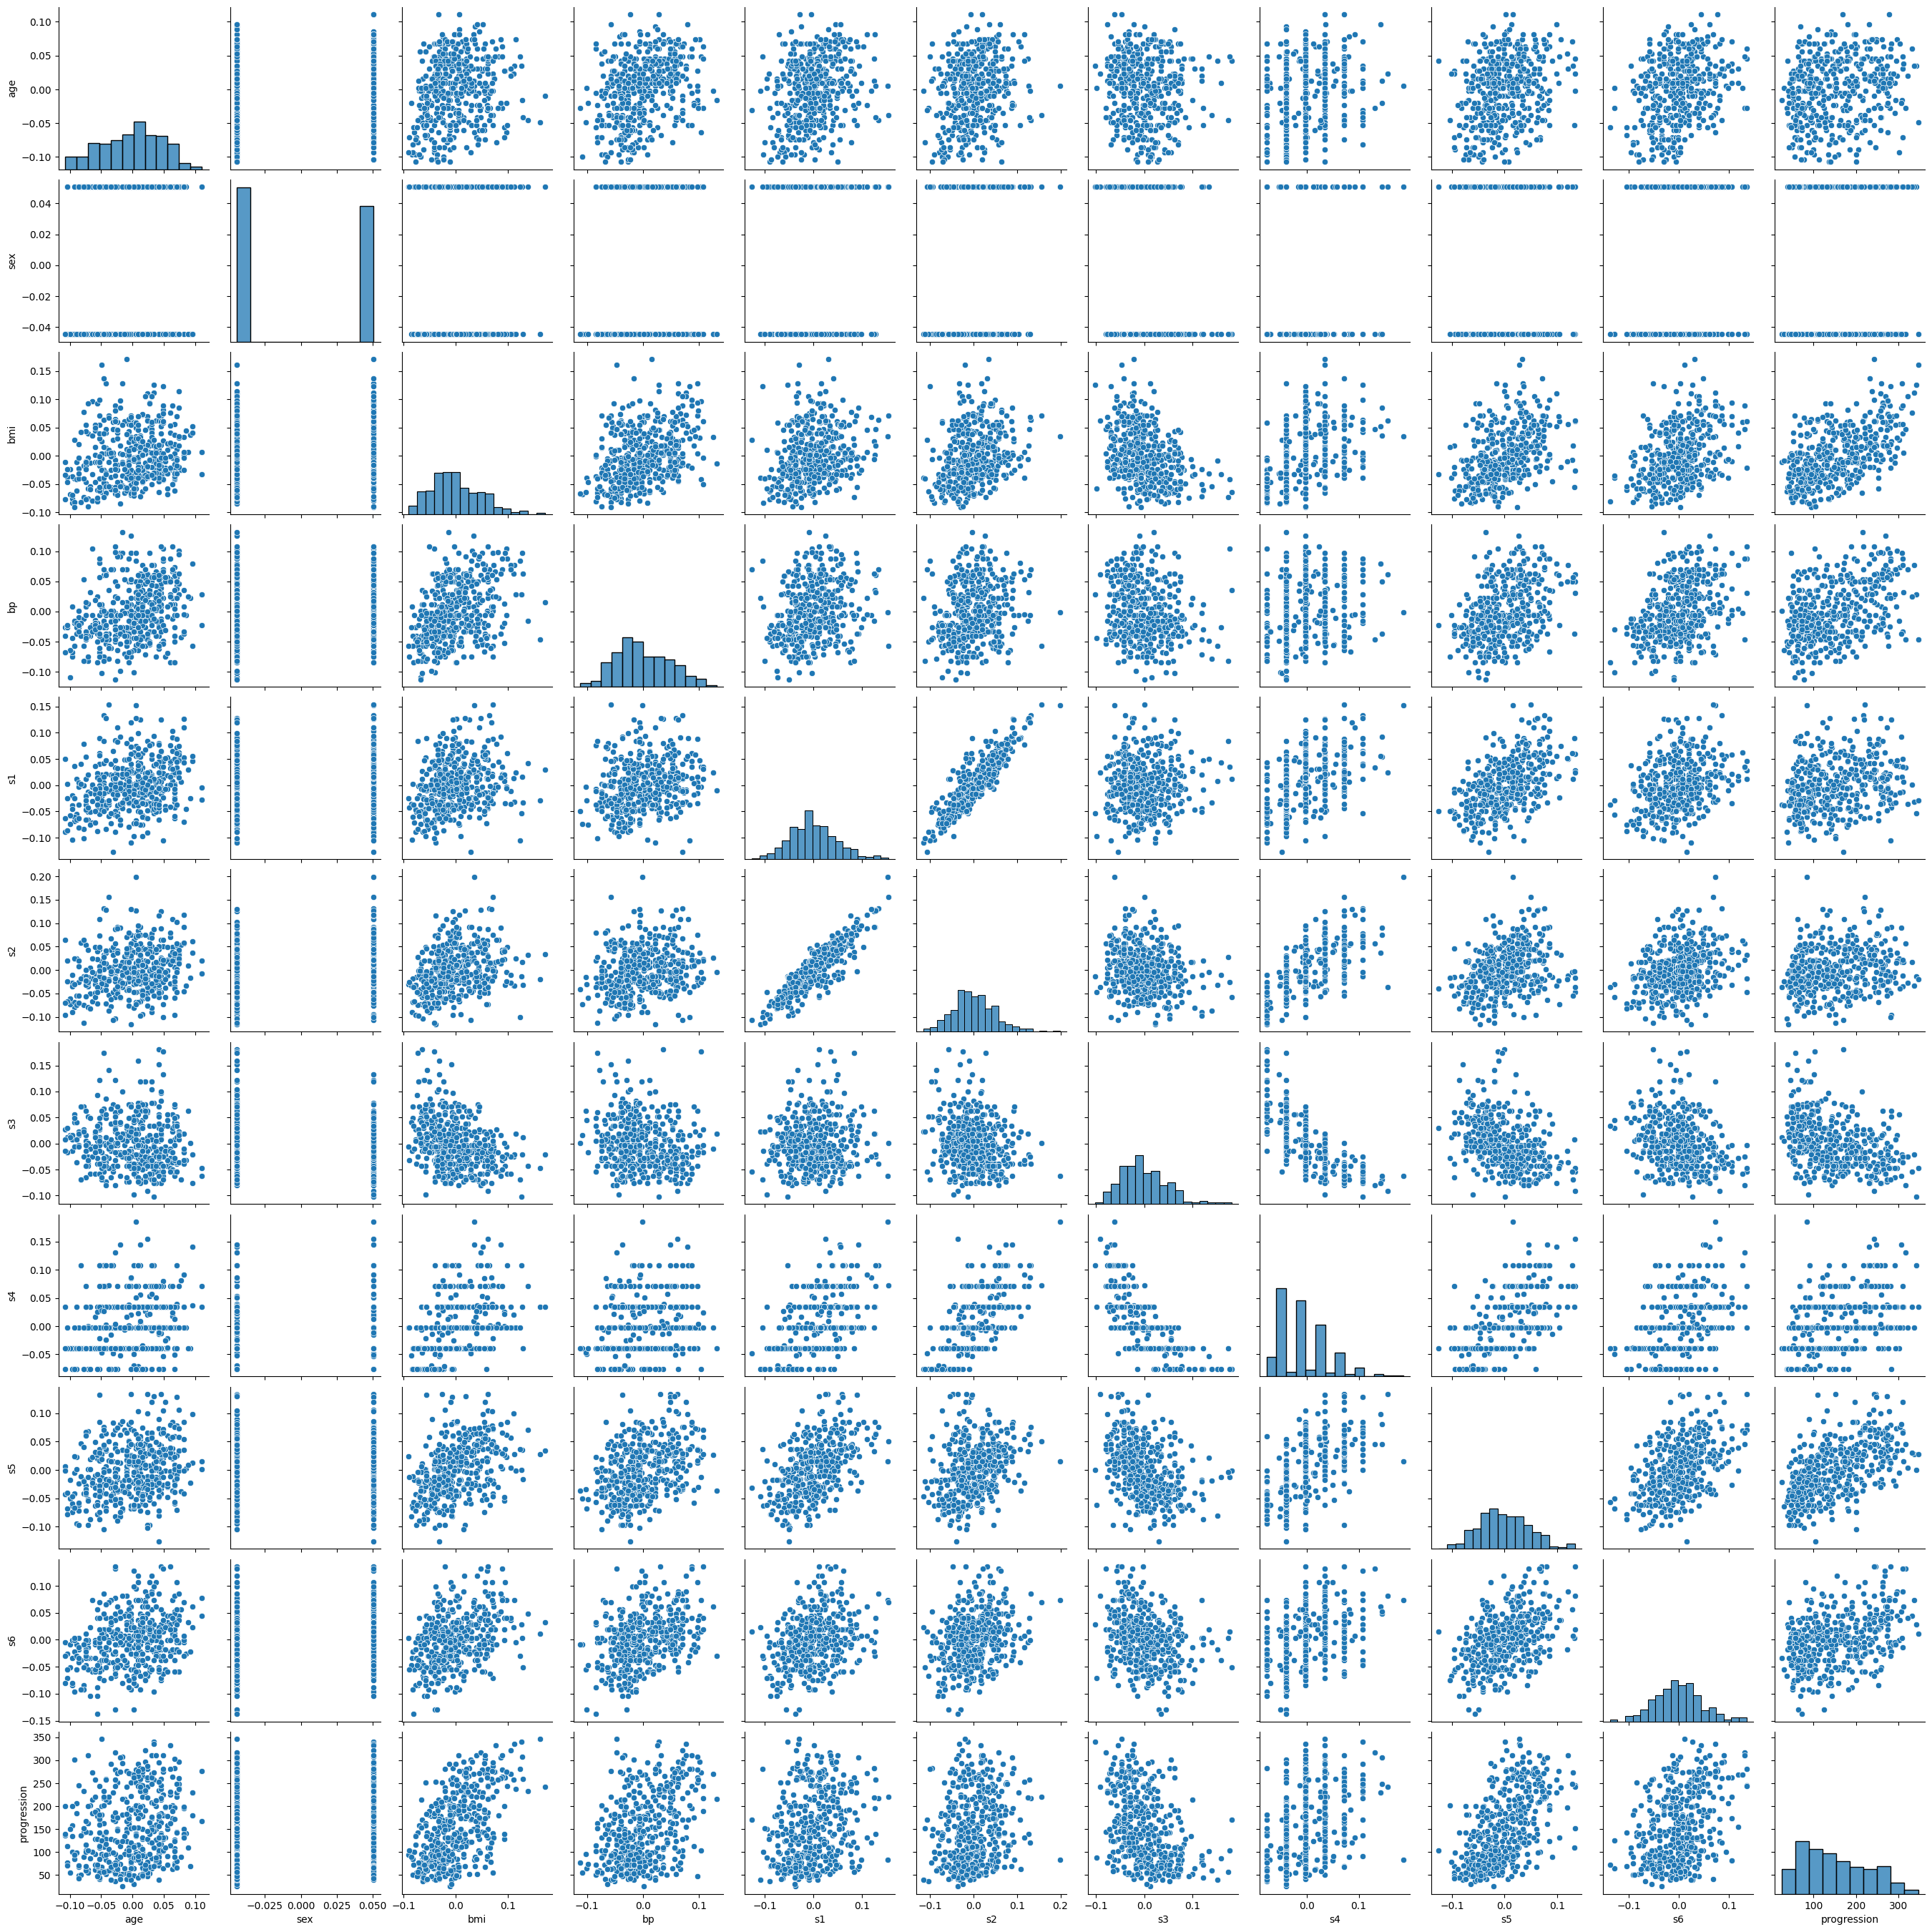


Correlation matrix heatmap showing the correlation coefficients between features:


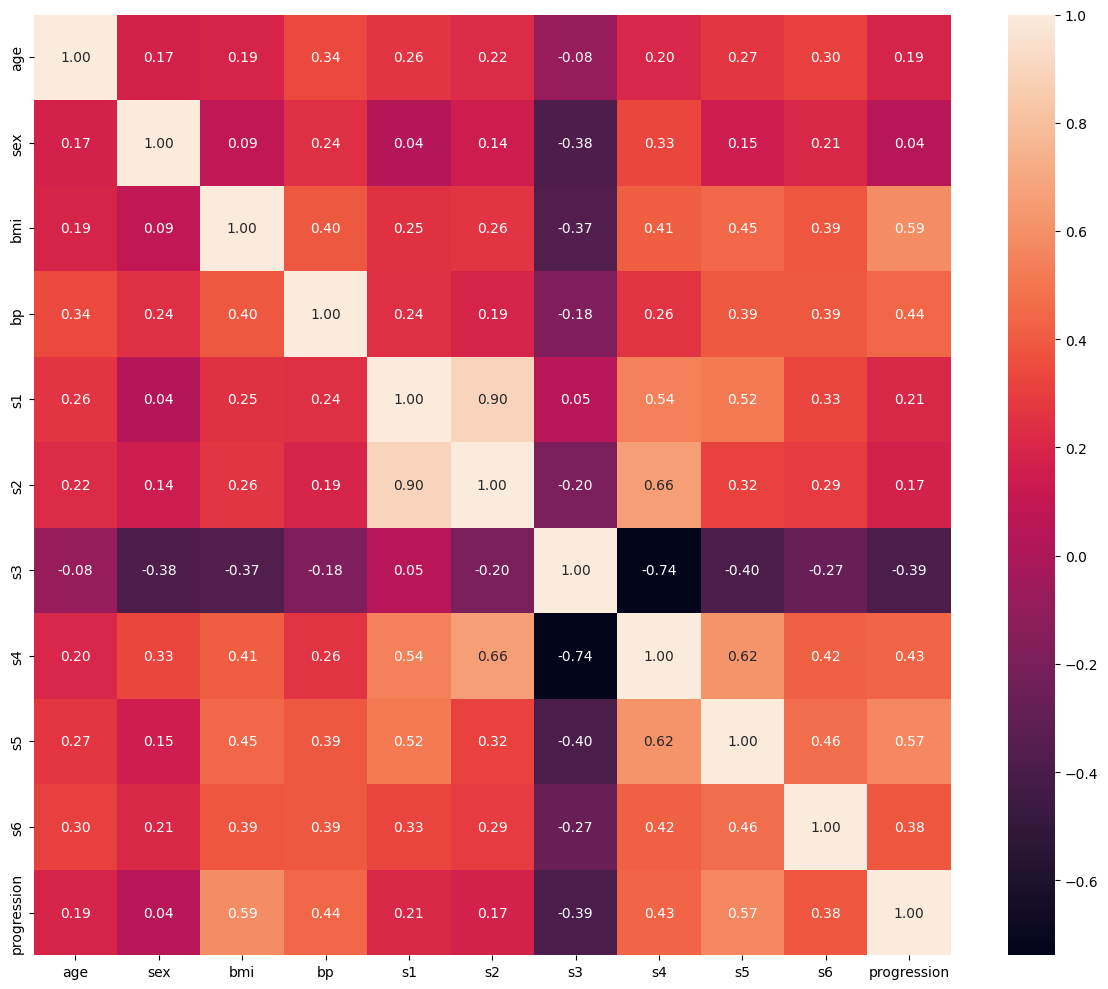


Histograms showing the distributions of each feature:


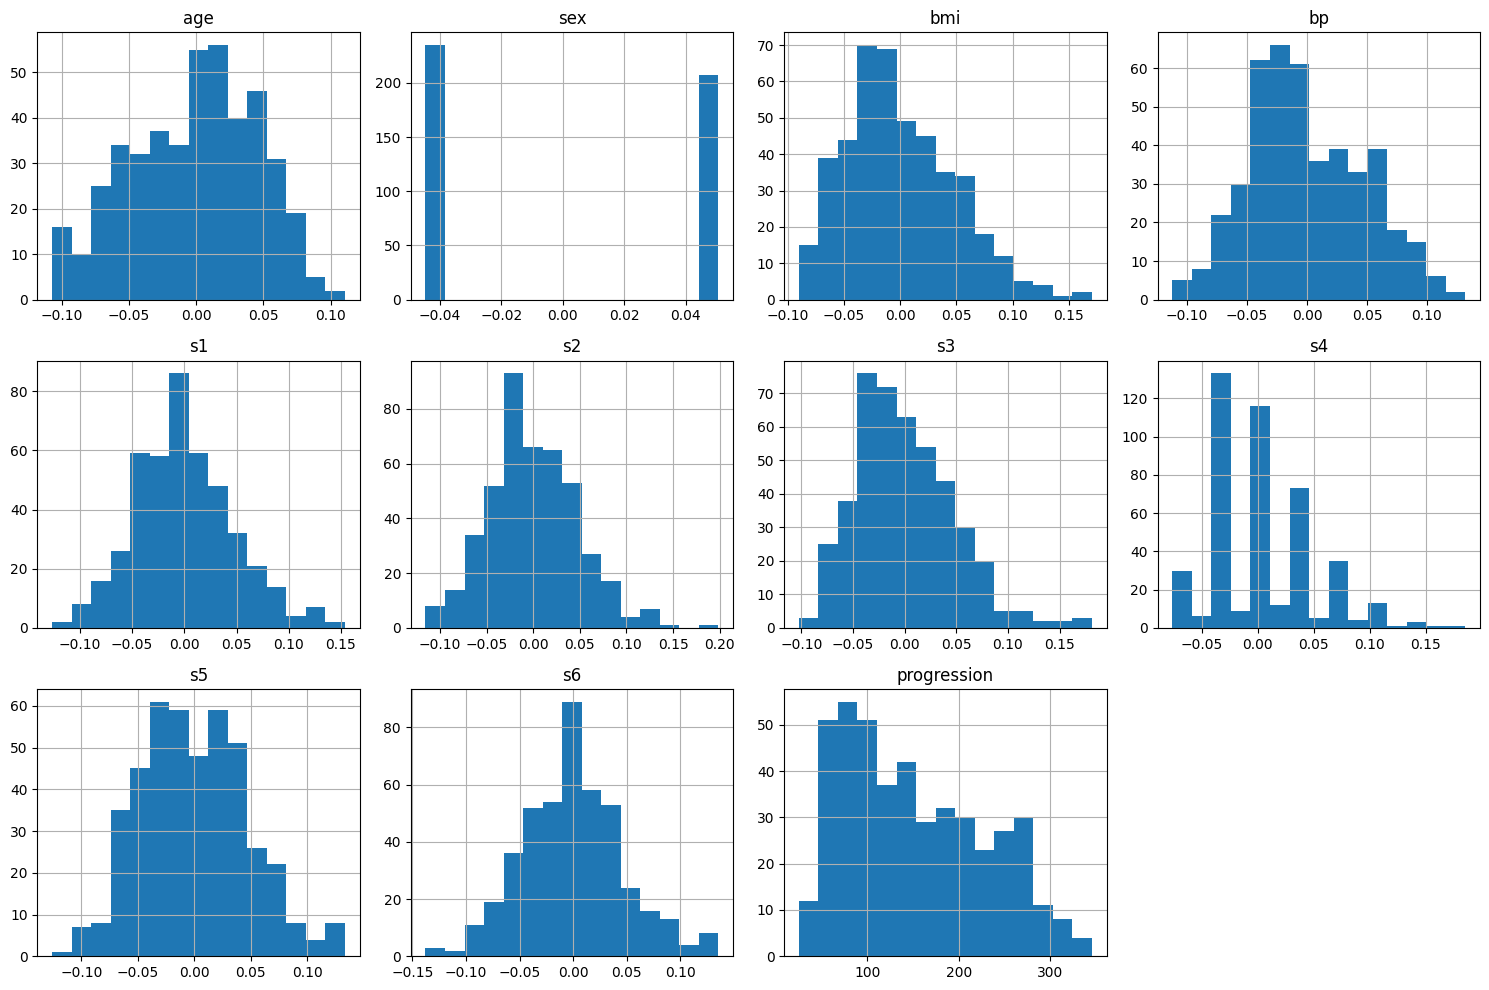


Box plots showing the distribution and potential outliers for each feature:


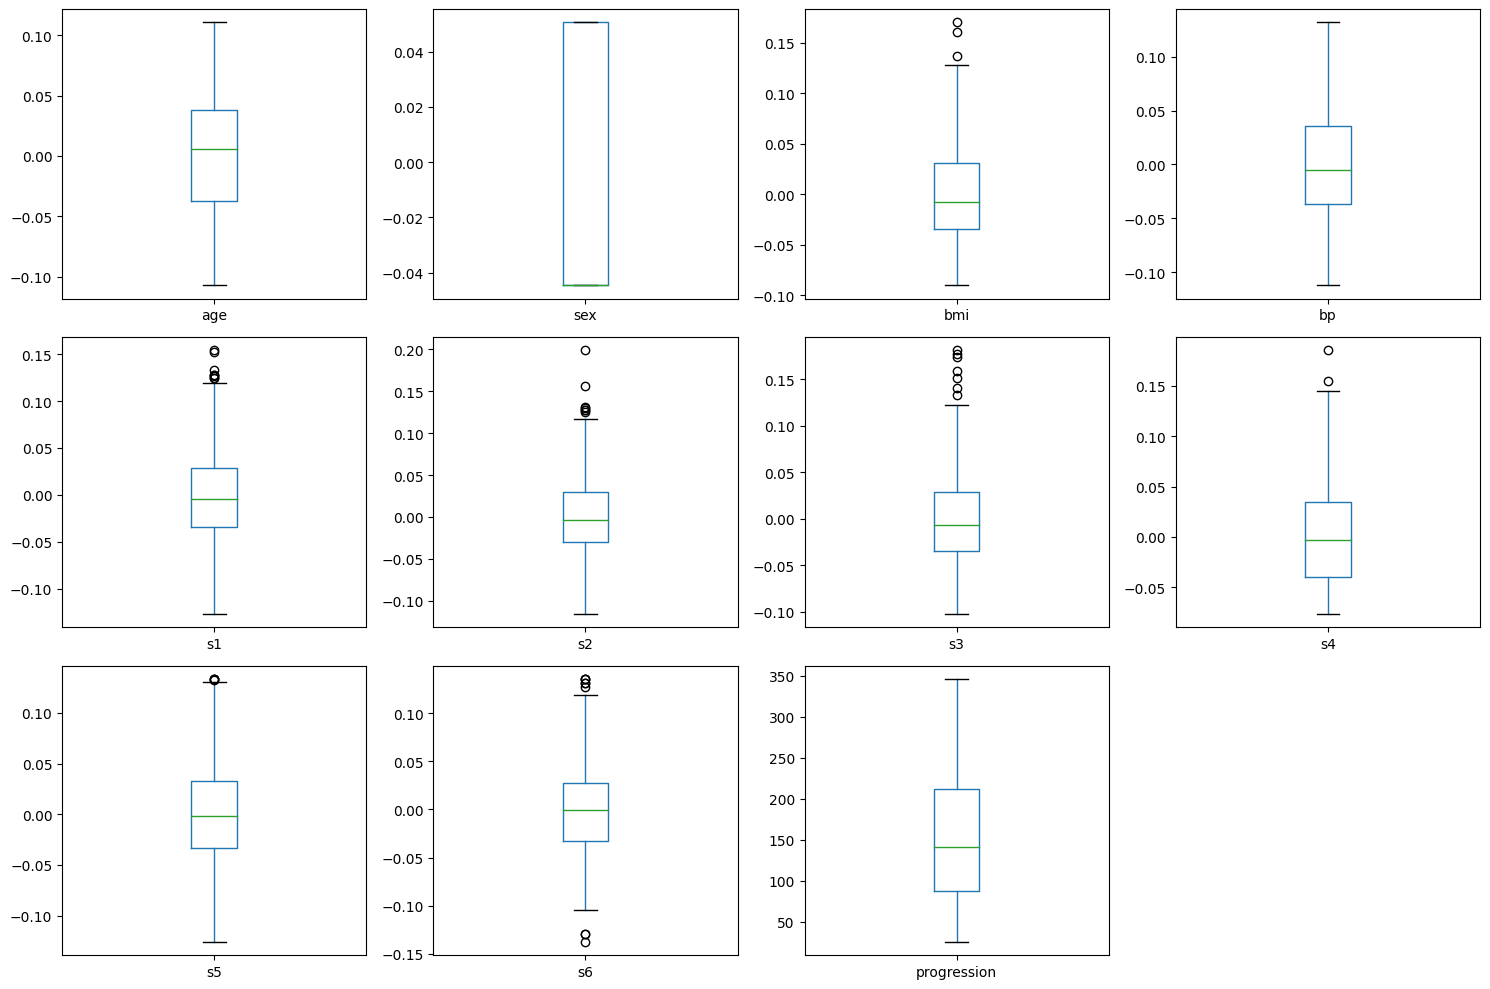


Scatter plots showing the relationships between each feature and the target variable 'progression':
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


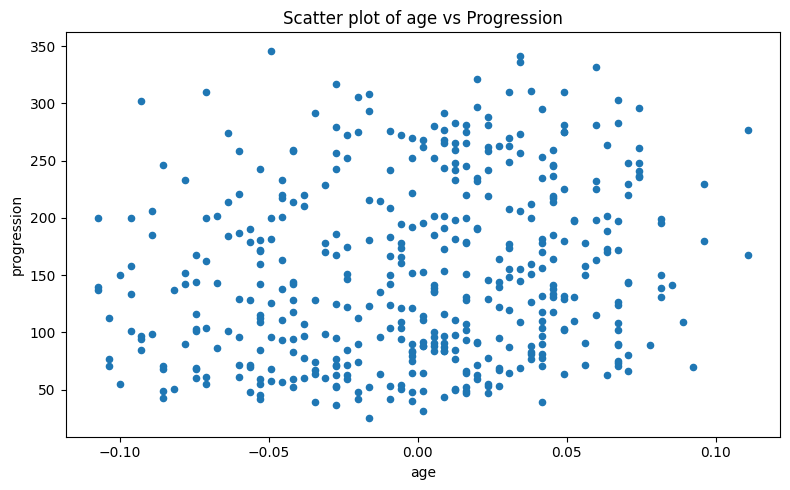

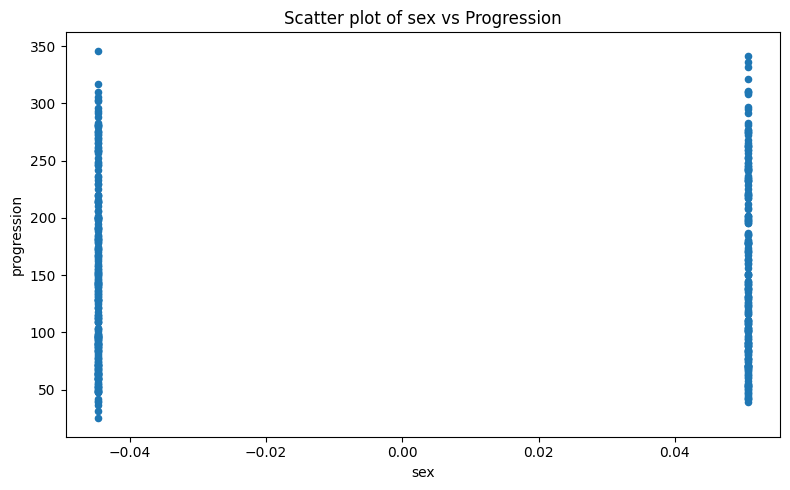

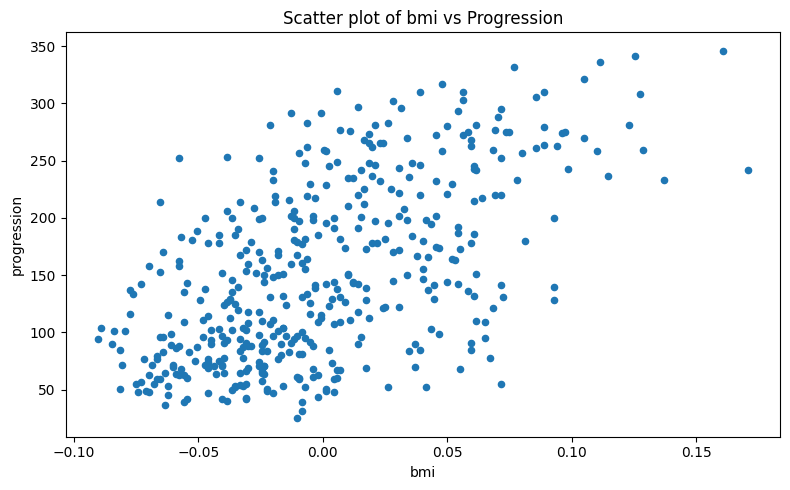

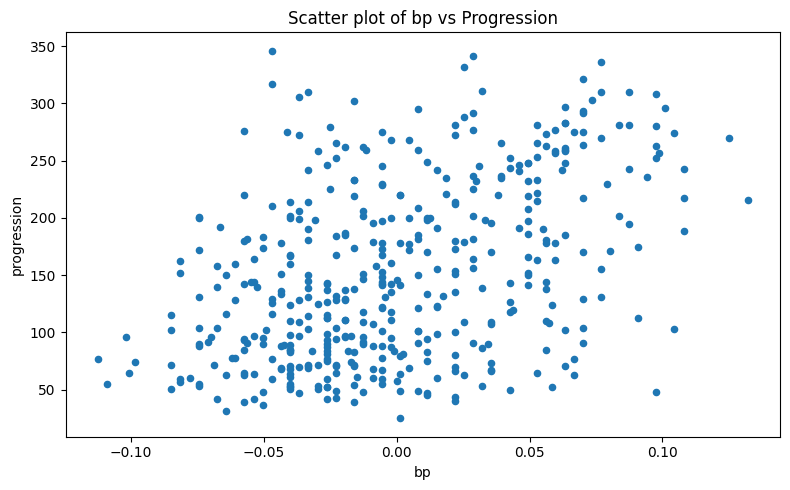

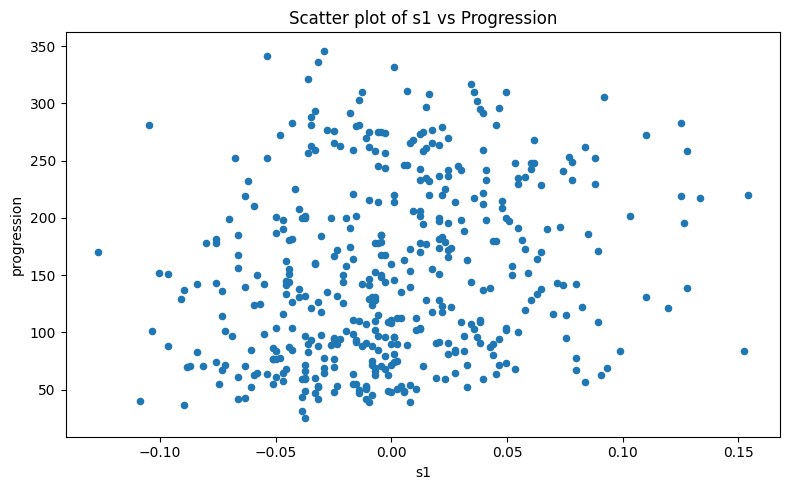

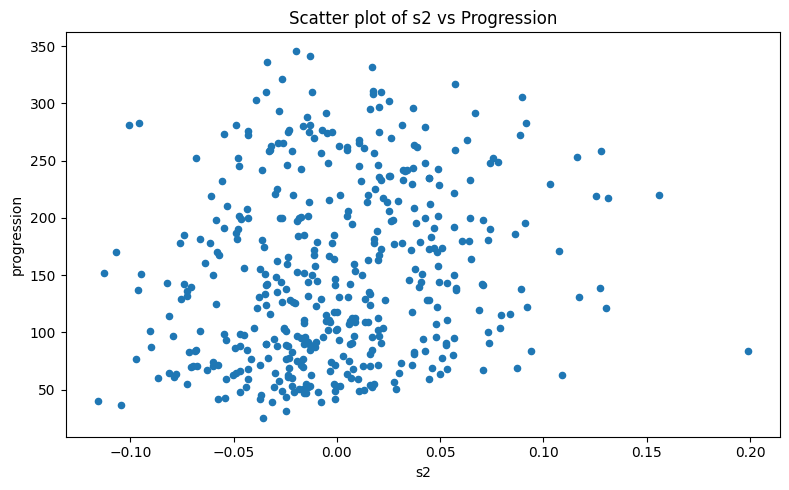

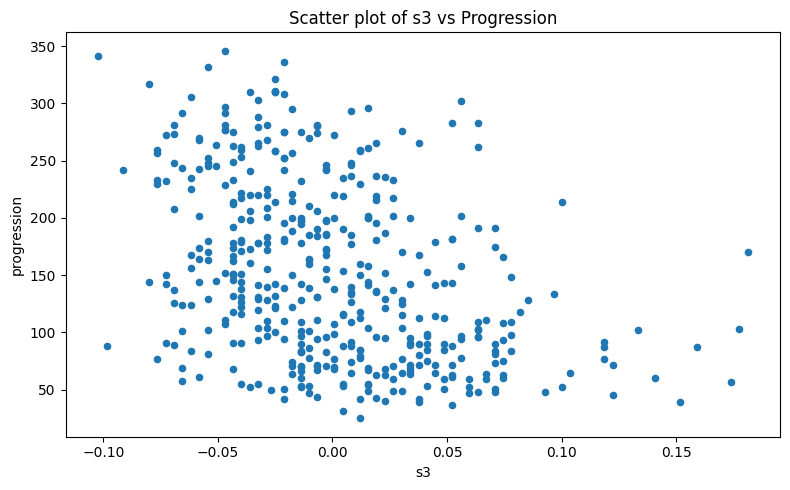

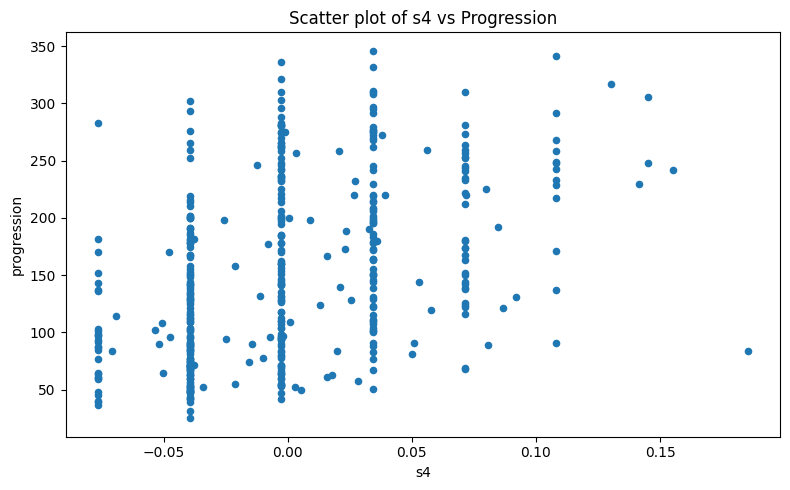

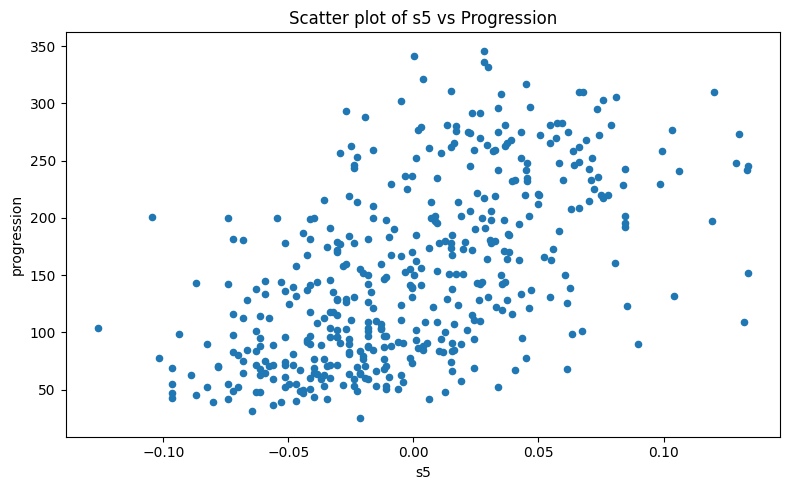

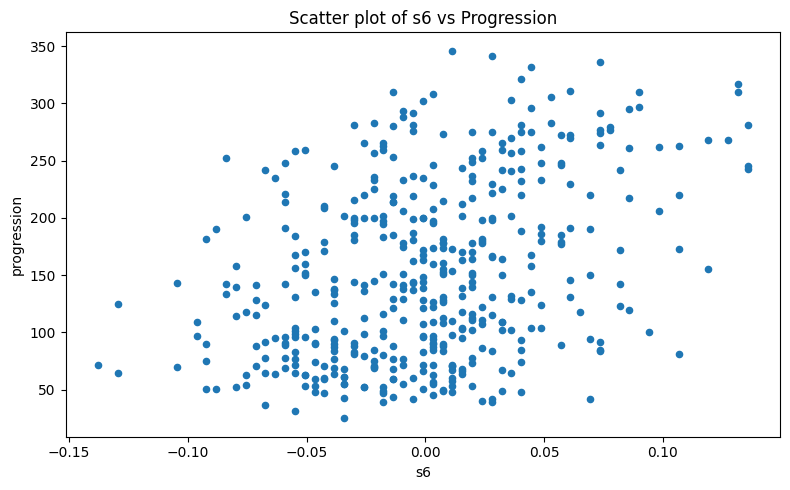

In [7]:
# Pairplot to visualize the distributions and relationships
print("\nPairplot showing the distributions and relationships between features:")
sns.pairplot(df)
plt.show()

# Correlation matrix heatmap
print("\nCorrelation matrix heatmap showing the correlation coefficients between features:")
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.show()

# Histograms to visualize the distributions of each feature
print("\nHistograms showing the distributions of each feature:")
df.hist(bins=15, figsize=(15, 10), layout=(3, 4))
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.show()

# Box plots to check for outliers in each feature
print("\nBox plots showing the distribution and potential outliers for each feature:")
df.plot(kind='box', subplots=True, layout=(3, 4), figsize=(15, 10))
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.show()

# Scatter plots with the target variable to visualize individual relationships
print("\nScatter plots showing the relationships between each feature and the target variable 'progression':")
for col in df.columns[:-1]:  # Exclude the target variable itself
    df.plot(kind='scatter', x=col, y='progression', figsize=(8, 5))
    plt.title(f'Scatter plot of {col} vs Progression')
    plt.tight_layout()  # Adjust the layout to fit the label and title
    plt.show()

In [8]:
!pip install torch_inspect==0.0.3

  Preparing metadata (setup.py) ... done
  Created wheel for torch_inspect: filename=torch_inspect-0.0.3-py3-none-any.whl size=9619 sha256=8c3caf1aed91a0be9356d77aa82e98e636e85c2659bbc7e975461996ab8fd816
  Stored in directory: /root/.cache/pip/wheels/d0/ef/a6/034ae6fb98775406186c4790858173b51746a48a279e48f022
Successfully built torch_inspect

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Plotting Using Pytorch and Matplotlib

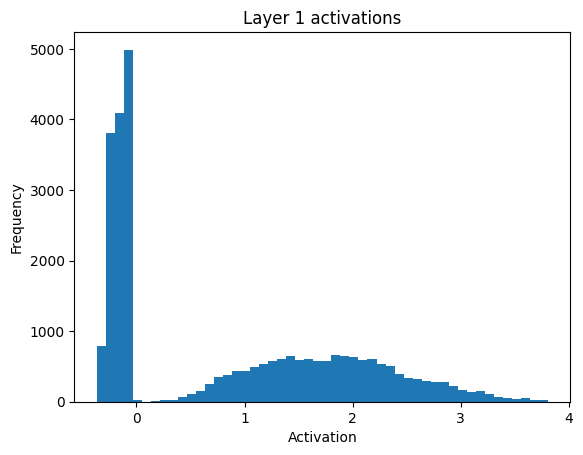

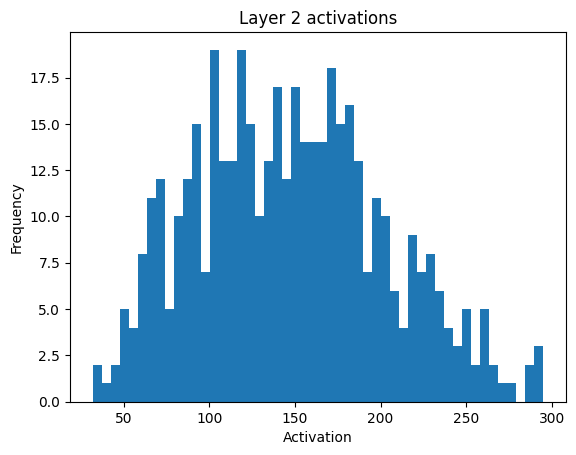

In [9]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the model architecture is the same as the one you saved earlier
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the diabetes dataset
data = pd.read_csv('diabetes_data.csv')

# Convert the data to PyTorch Tensors and normalize if necessary
x = torch.tensor(data.drop('progression', axis=1).values, dtype=torch.float32)
y = torch.tensor(data['progression'].values, dtype=torch.float32)

# Initialize the model
input_size = x.size(1)
model = Net(input_size)

# Load the saved state dictionary into the model
state_dict = torch.load('diabetes_model.pt')
model.load_state_dict(state_dict)

# Set model to evaluation mode
model.eval()

# Now let's plot the histogram of activations for each layer
# We will collect activations in a forward hook
activations = []

def get_activation(layer, input, output):
    activations.append(output.detach())

# Register hook for each layer
hooks = []
for layer in model.children():
    hooks.append(layer.register_forward_hook(get_activation))

# Forward pass through the model
with torch.no_grad():
    model(x)

# Remove hooks (good practice to avoid memory leaks)
for hook in hooks:
    hook.remove()

# Plotting the activations
for i, activation in enumerate(activations):
    plt.hist(activation.numpy().flatten(), bins=50)
    plt.title(f'Layer {i+1} activations')
    plt.xlabel('Activation')
    plt.ylabel('Frequency')
    plt.show()


## Train models using pytorch

Before training the models we do the following things

- Remove Nan and Null values since our dataset has no such values we can skip it

- Remove outliers by using Z-Score

- Consider only highly correlated features with the target variable

- Perform Feature Scaling and Feature Engineering

### Remove Outliers Using Z-Scores

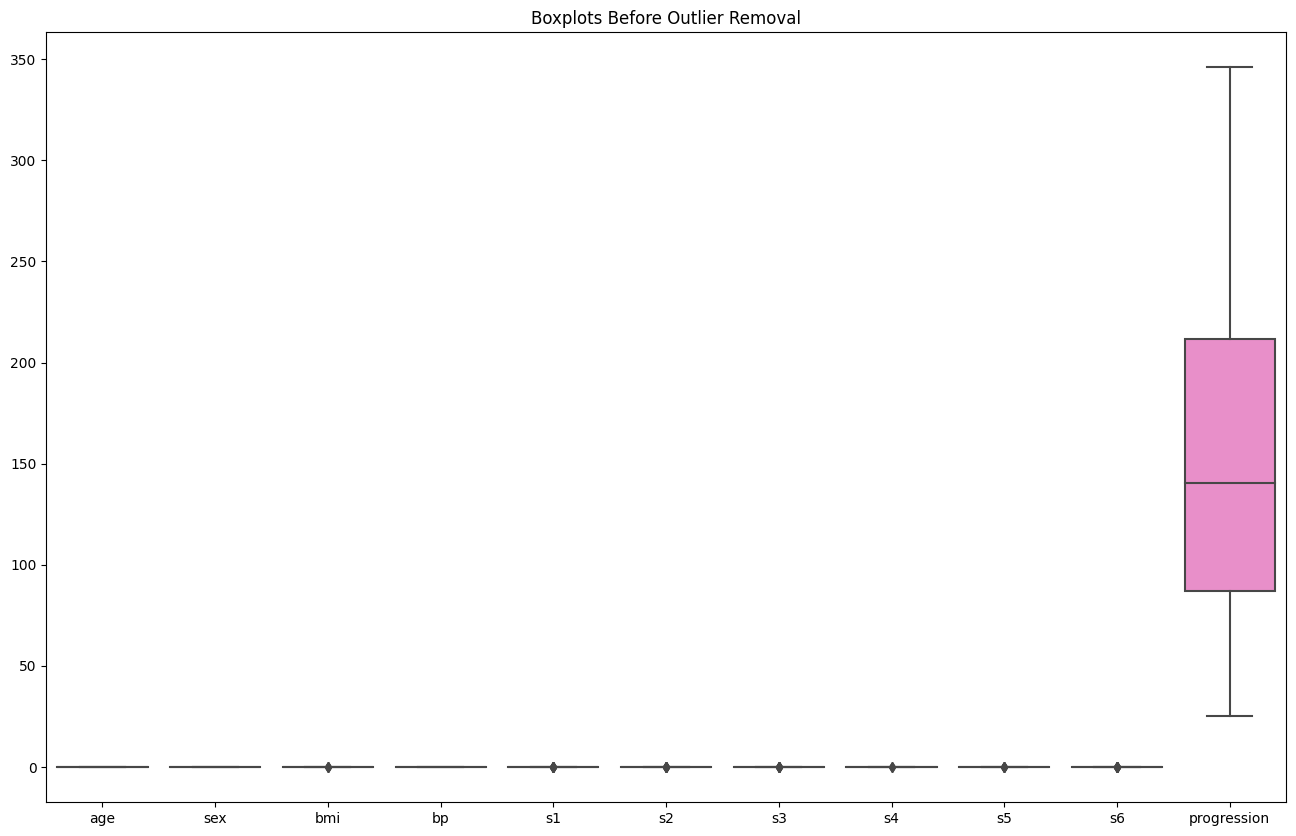

Number of outliers removed: 12


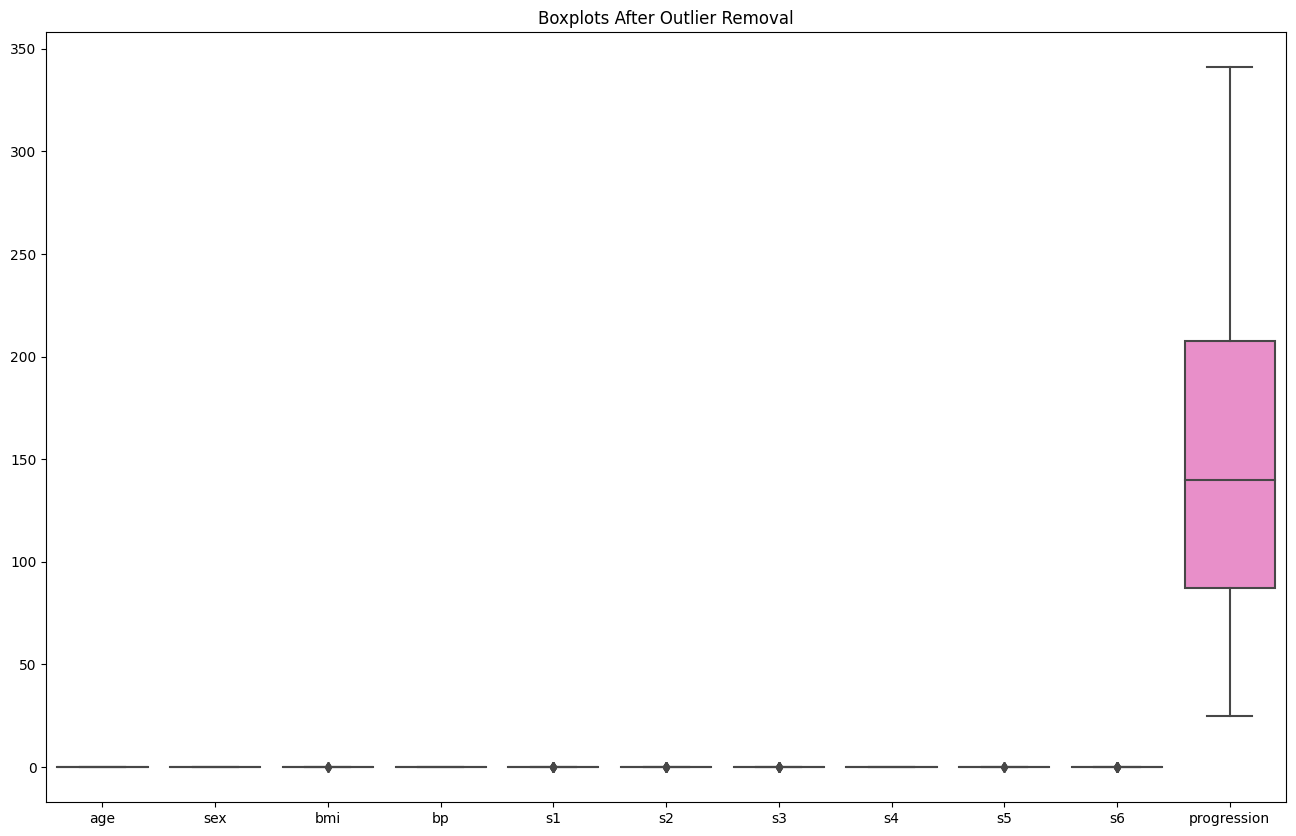

In [10]:
# Visualize boxplots before outlier removal
plt.figure(figsize=(16, 10))
sns.boxplot(data=df)
plt.title('Boxplots Before Outlier Removal')
plt.show()

# Calculate Z-scores
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)

# Filter out the outliers
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_no_outliers = df[filtered_entries]

# Calculate and print the number of outliers removed
outliers_removed = len(df) - len(df_no_outliers)
print(f'Number of outliers removed: {outliers_removed}')

# Visualize boxplots after outlier removal
plt.figure(figsize=(16, 10))
sns.boxplot(data=df_no_outliers)
plt.title('Boxplots After Outlier Removal')
plt.show()


Correlation Matrix Calculation: The code computes a correlation matrix (corr_matrix) for a pandas DataFrame (df). The correlation matrix quantifies the linear relationships between all pairs of features in the DataFrame.

High Correlation Threshold: It sets a threshold (threshold = 0.35) to identify 'highly correlated' features. Pairs of features with an absolute correlation coefficient higher than this threshold are considered to be strongly correlated.

Identify and Print Pairs: The code identifies pairs of features with high correlation and prints them out, excluding self-correlations (a feature correlated with itself). It also visualizes the entire correlation matrix using a heatmap.

Feature Selection: It determines which features to remove based on their correlation with other features. Features that are not part of any highly correlated pair (below the threshold) are deemed less important and are listed to be removed.

DataFrame Reduction: The code creates a reduced DataFrame (df_reduced) by dropping the features identified as less correlated, thereby potentially improving the model's performance by removing redundant data. It then prints the features that were removed and displays the modified DataFrame.

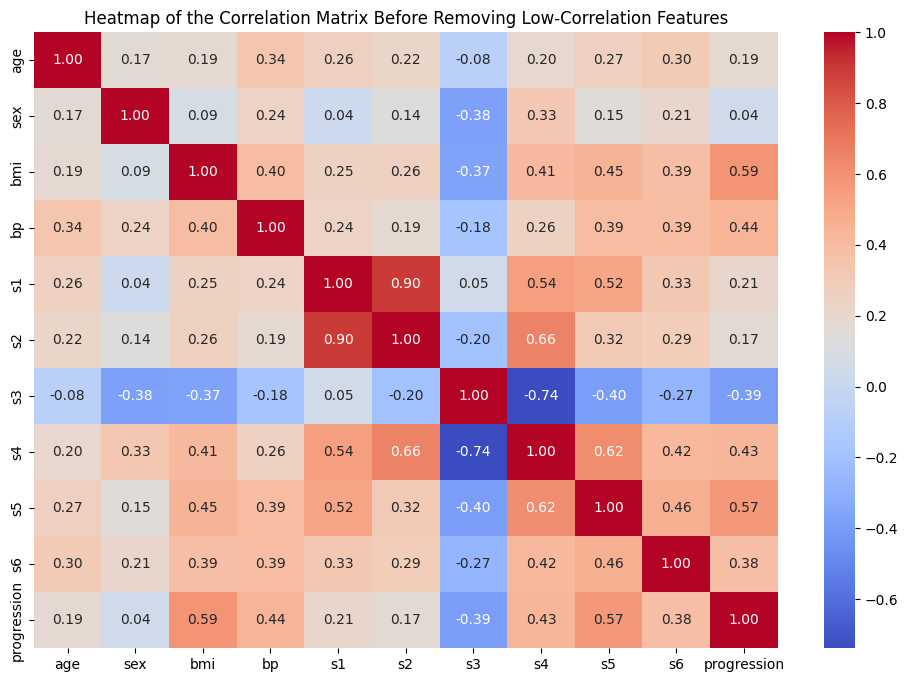

Highly correlated features with progression to be considered: ['bmi', 'bp', 's4', 's5']
Features removed due to low correlation with progression: ['age', 'sex', 's1', 's2', 's3', 's6']


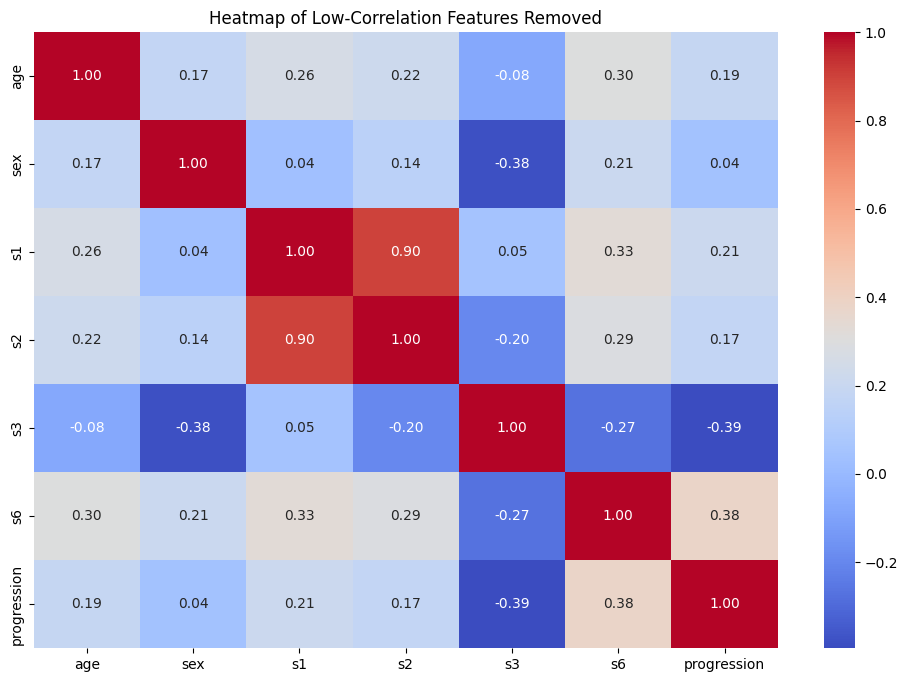

Modified DataFrame with Highly Correlated Features:
          bmi        bp        s4        s5  progression
0    0.061696  0.021872 -0.002592  0.019907        151.0
1   -0.051474 -0.026328 -0.039493 -0.068332         75.0
2    0.044451 -0.005670 -0.002592  0.002861        141.0
3   -0.011595 -0.036656  0.034309  0.022688        206.0
4   -0.036385  0.021872 -0.002592 -0.031988        135.0
5   -0.040696 -0.019442 -0.076395 -0.041176         97.0
6   -0.047163 -0.015999 -0.039493 -0.062917        138.0
7   -0.001895  0.066629  0.017703 -0.035816         63.0
8    0.061696 -0.040099 -0.002592 -0.014960        110.0
9    0.039062 -0.033213 -0.002592  0.067737        310.0
10  -0.083808  0.008101 -0.076395 -0.062917        101.0
11   0.017506 -0.033213  0.071210 -0.096435         69.0
12  -0.028840 -0.009113 -0.039493 -0.030748        179.0
13  -0.001895  0.008101 -0.002592  0.038394        185.0
14  -0.025607 -0.012556 -0.039493 -0.031988        118.0
15  -0.018062  0.080401  0.108111  0

In [11]:
# Assuming 'df' is your DataFrame and 'progression' is the target column
target_column = 'progression'  # Replace with your actual target column name if different

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the heatmap of the correlation matrix before removing low-correlation features
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap of the Correlation Matrix Before Removing Low-Correlation Features')
plt.show()

# Consider a feature highly correlated when the absolute correlation coefficient is above a threshold, e.g., 0.5
threshold = 0.40
features_to_consider = correlation_matrix.index[abs(correlation_matrix[target_column]) > threshold].tolist()
features_to_remove = correlation_matrix.index[abs(correlation_matrix[target_column]) <= threshold].tolist()

# Remove the target variable from the features to consider if it's included
if target_column in features_to_consider:
    features_to_consider.remove(target_column)

print(f'Highly correlated features with progression to be considered: {features_to_consider}')
print(f'Features removed due to low correlation with progression: {features_to_remove}')

# Show heatmap with low-correlation features to be removed
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.drop(features_to_consider, axis=0).drop(features_to_consider, axis=1), 
            annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap of Low-Correlation Features Removed')
plt.show()

# Create a DataFrame with only highly correlated features and the target variable
df_highly_correlated = df[features_to_consider + [target_column]]

# Show the modified DataFrame with highly correlated features
print("Modified DataFrame with Highly Correlated Features:")
print(df_highly_correlated.to_string())


### Perform Feature Engineering

In [12]:
from sklearn.preprocessing import PolynomialFeatures

# Assuming df_no_outliers is your DataFrame from which outliers have been removed
X = df_highly_correlated[['bmi', 'bp', 's4', 's5']]  # Features
y = df_highly_correlated['progression']  # Target

# Initialize a PolynomialFeatures object
poly = PolynomialFeatures(degree=2, include_bias=False)

# Create polynomial features
X_poly = poly.fit_transform(X)

# Convert the array back to a DataFrame (for better visualization and further processing)
columns = poly.get_feature_names(['bmi', 'bp', 's4', 's5'])
df_poly = pd.DataFrame(X_poly, columns=columns)

# Check the head of the dataframe to see the engineered features
print(df_poly.head())

# Now df_poly contains the original features plus the polynomial features


        bmi        bp        s4        s5     bmi^2    bmi bp    bmi s4  \
0  0.061696  0.021872 -0.002592  0.019907  0.003806  0.001349 -0.000160   
1 -0.051474 -0.026328 -0.039493 -0.068332  0.002650  0.001355  0.002033   
2  0.044451 -0.005670 -0.002592  0.002861  0.001976 -0.000252 -0.000115   
3 -0.011595 -0.036656  0.034309  0.022688  0.000134  0.000425 -0.000398   
4 -0.036385  0.021872 -0.002592 -0.031988  0.001324 -0.000796  0.000094   

     bmi s5      bp^2     bp s4     bp s5      s4^2     s4 s5      s5^2  
0  0.001228  0.000478 -0.000057  0.000435  0.000007 -0.000052  0.000396  
1  0.003517  0.000693  0.001040  0.001799  0.001560  0.002699  0.004669  
2  0.000127  0.000032  0.000015 -0.000016  0.000007 -0.000007  0.000008  
3 -0.000263  0.001344 -0.001258 -0.000832  0.001177  0.000778  0.000515  
4  0.001164  0.000478 -0.000057 -0.000700  0.000007  0.000083  0.001023  
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Fun

### Perform Feature Scaling

Scaling features to a similar range can make the training process more stable and often faster, with less risk of getting stuck in local optima. For gradient-based methods, it also ensures that the gradient descent moves smoothly towards the minima and that the steps taken in the parameter space are proportional.

We use the `MinMaxScaler` is useful when you want to scale features to a specific range, typically [0, 1], which is particularly beneficial for algorithms that expect data to be within certain bounds, such as neural networks, or for visual representation purposes. It is well-suited for models that are sensitive to the scale of data and do not assume any specific distribution, including those based on gradient descent and distance calculations like k-NN. However, it's important to note that `MinMaxScaler` is sensitive to outliers, which can distort the actual data range and impact the scaling of the rest of the data. This could potentially affect model performance if outliers are present.

In [13]:


min_max_scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
scaled_data = min_max_scaler.fit_transform(df)

# Convert the scaled array back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

# Show the first few rows of the scaled data
print(scaled_df.head())


        age  sex       bmi        bp        s1        s2        s3        s4  \
0  0.666667  1.0  0.582645  0.549296  0.294118  0.256972  0.207792  0.282087   
1  0.483333  0.0  0.148760  0.352113  0.421569  0.306773  0.623377  0.141044   
2  0.883333  1.0  0.516529  0.436620  0.289216  0.258964  0.246753  0.282087   
3  0.083333  0.0  0.301653  0.309859  0.495098  0.447211  0.233766  0.423131   
4  0.516667  0.0  0.206612  0.549296  0.465686  0.417331  0.389610  0.282087   

         s5        s6  progression  
0  0.562217  0.439394     0.392523  
1  0.222437  0.166667     0.155763  
2  0.496578  0.409091     0.361371  
3  0.572923  0.469697     0.563863  
4  0.362385  0.333333     0.342679  


### Now for training the model with pytorch we do the following:

- Convert dataframe to numpy for processing with PyTorch

- Since the dataset is time-sensitive, we use TimeSeriesSplit for creating our training/validation sets.

- Converting to pytorch sensors

- Creating TensorDatasets for our DataLoader

- DataLoaders handle batching of data during training

In [14]:

# Convert dataframe to numpy for processing with PyTorch

features = scaled_df.iloc[:, :-1].to_numpy()
targets = scaled_df.iloc[:, -1].to_numpy()

# Since the dataset is time-sensitive, we use TimeSeriesSplit for creating our training/validation sets.
tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(features):
    features_train, features_val = features[train_index], features[val_index]
    targets_train, targets_val = targets[train_index], targets[val_index]

# Converting numpy arrays to PyTorch tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
targets_train_tensor = torch.tensor(targets_train, dtype=torch.float32).view(-1, 1)
features_val_tensor = torch.tensor(features_val, dtype=torch.float32)
targets_val_tensor = torch.tensor(targets_val, dtype=torch.float32).view(-1, 1)

# Creating TensorDatasets for our DataLoader
train_dataset = TensorDataset(features_train_tensor, targets_train_tensor)
val_dataset = TensorDataset(features_val_tensor, targets_val_tensor)

# DataLoaders handle batching of data during training
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

### We use the following models:

-  MLP model with two hidden layers

- A simple Linear Regression model which is equivalent to a single-layer perceptron without activation

-  DNN model with two hidden layers


In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(), # Activation function for first hidden layer
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(), # Activation function for second hidden layer
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        return self.layers(x)


In [16]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [17]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(), # Activation function for first hidden layer
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(), # Activation function for second hidden layer
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        return self.layers(x)


### We instiantiate the models with the following parameters:

- input_size: The size of the input:

- output_size: Regression has one output value

- hidden_size1 = 64:  Size of first hidden layer

- hidden_size2 = 32:Size of second hidden layer

In [18]:
input_size = features_train_tensor.shape[1] 
output_size = 1 
hidden_size1 = 64 
hidden_size2 = 32 

models = {
    'MLP': MLP(input_size, hidden_size1, hidden_size2, output_size),
    'LinearRegression': LinearRegression(input_size, output_size),
    'DNN': DNN(input_size, hidden_size1, hidden_size2, output_size)
}


### We Define the following loss functions:

- MSE (Mean Squared Error): It is the average of the squared differences between the predicted and actual values, emphasizing larger errors.

- MAE (Mean Absolute Error): It is the average of the absolute differences between the predicted and actual values, giving equal weight to all errors.

### We define the following Optimizers:

- SGD (Stochastic Gradient Descent): It updates parameters using a fixed learning rate and based on the gradient of the loss with respect to a single batch; 

- Adam (Adaptive Moment Estimation): It adapts the learning rate for each parameter by estimating first and second moments of the gradients.

- RMSProp (Root Mean Square Propagation): It adjusts the learning rate by dividing the gradient by a running average of its recent magnitude.

The learning rate is a hyperparameter that controls the step size at each iteration while moving toward a minimum of a loss function in the training of neural networks.

We define the learning rate of 0.01

An epoch in machine learning is one complete pass through the entire training dataset during the learning process of an algorithm.

We define 100 epochs

In [19]:
# Define loss functions and optimizer choices
loss_functions = {'MSE': nn.MSELoss(), 'MAE': nn.L1Loss()}
optimizers = {'SGD': optim.SGD, 'Adam': optim.Adam, 'RMSProp': optim.RMSprop}

# Set a learning rate for the optimizer
learning_rate = 0.01
num_epochs = 100 # Number of epochs to train for
loss_history = {name: {'train': [], 'val': []} for name in models} # Dictionary to store loss history


### Train the models

In [20]:

for name, model in models.items():
    print(f"Training {name} model...")
    optimizer = optimizers['Adam'](model.parameters(), lr=learning_rate) # Choosing Adam optimizer
    loss_fn = loss_functions['MSE'] # Choosing Mean Squared Error loss function for regression task

    # Training loop
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        epoch_loss = 0.0
        for batch_features, batch_targets in train_loader:
            # Zero the gradients before running the backward pass.
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            predictions = model(batch_features)
            # Compute loss
            loss = loss_fn(predictions, batch_targets)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Accumulate loss
            epoch_loss += loss.item() * batch_features.size(0) # Multiply by batch size to get absolute batch loss

        # Compute average loss over the epoch
        epoch_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval() # Set model to evaluation mode
        with torch.no_grad(): # Turn off gradients for validation, saves memory and computations
            val_loss = sum(loss_fn(model(batch_features), batch_targets).item() *
                           batch_features.size(0) for batch_features, batch_targets in val_loader)
        val_loss /= len(val_loader.dataset)
        
        # Store losses for plotting
        loss_history[name]['train'].append(epoch_loss)
        loss_history[name]['val'].append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')


Training MLP model...
Epoch [1/100]: Train Loss: 0.0697, Validation Loss: 0.0422
Epoch [2/100]: Train Loss: 0.0409, Validation Loss: 0.0352
Epoch [3/100]: Train Loss: 0.0344, Validation Loss: 0.0282
Epoch [4/100]: Train Loss: 0.0305, Validation Loss: 0.0254
Epoch [5/100]: Train Loss: 0.0291, Validation Loss: 0.0250
Epoch [6/100]: Train Loss: 0.0286, Validation Loss: 0.0245
Epoch [7/100]: Train Loss: 0.0283, Validation Loss: 0.0246
Epoch [8/100]: Train Loss: 0.0280, Validation Loss: 0.0241
Epoch [9/100]: Train Loss: 0.0279, Validation Loss: 0.0241
Epoch [10/100]: Train Loss: 0.0277, Validation Loss: 0.0239
Epoch [11/100]: Train Loss: 0.0276, Validation Loss: 0.0237
Epoch [12/100]: Train Loss: 0.0274, Validation Loss: 0.0240
Epoch [13/100]: Train Loss: 0.0274, Validation Loss: 0.0237
Epoch [14/100]: Train Loss: 0.0273, Validation Loss: 0.0236
Epoch [15/100]: Train Loss: 0.0270, Validation Loss: 0.0240
Epoch [16/100]: Train Loss: 0.0271, Validation Loss: 0.0238
Epoch [17/100]: Train Loss:

Plot training and validation losses. This can be useful to see how the losses change over time and detect overfitting

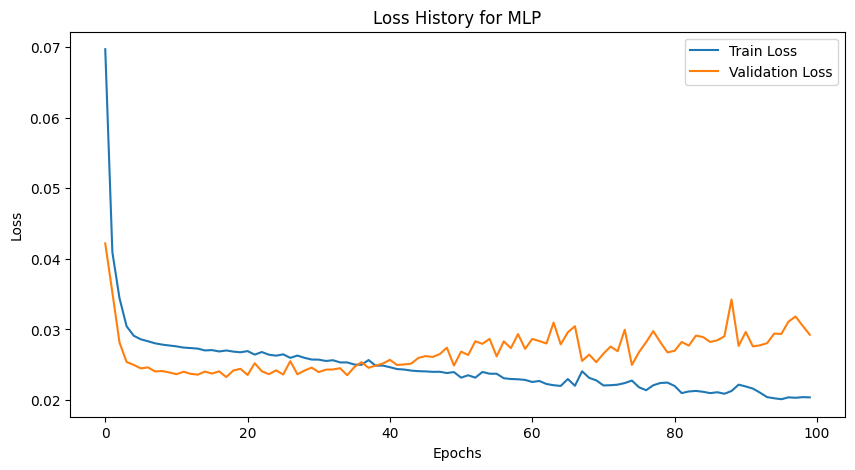

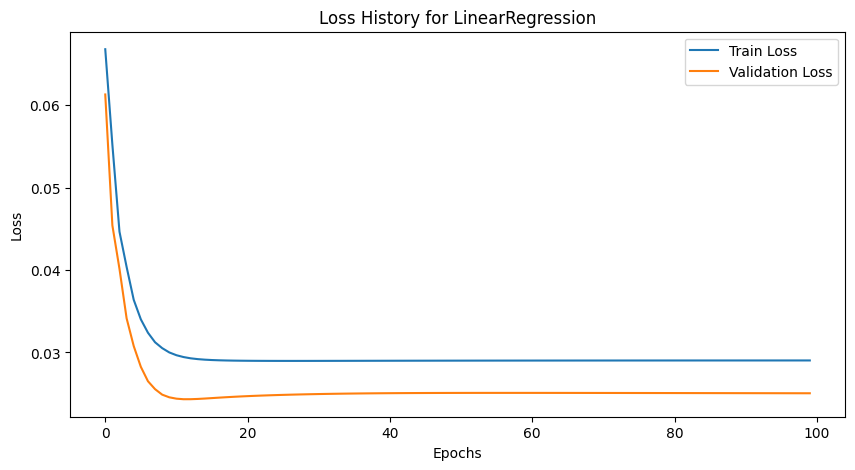

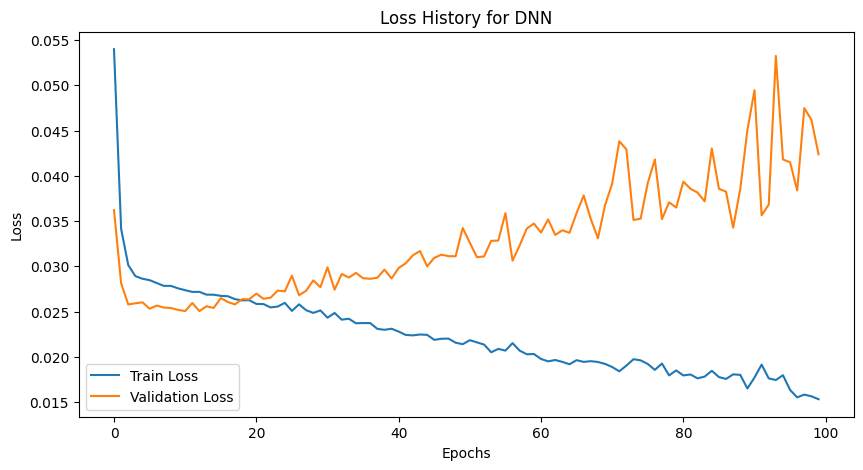

In [21]:
for name in models:
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history[name]['train'], label='Train Loss')
    plt.plot(loss_history[name]['val'], label='Validation Loss')
    plt.title(f'Loss History for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Determine the best training model by comparing the loss

In [22]:
# Find the model with the lowest average validation loss
avg_val_losses = {name: np.mean(history['val']) for name, history in loss_history.items()}
best_model_name = min(avg_val_losses, key=avg_val_losses.get)
best_model = models[best_model_name]

print(f"The best model is {best_model_name} with an average validation loss of {avg_val_losses[best_model_name]:.4f}")

# Best model's parameters
best_model_parameters = best_model.state_dict()


The best model is LinearRegression with an average validation loss of 0.0259


### Perform predictions and review model loss

Validation Loss: 0.0251


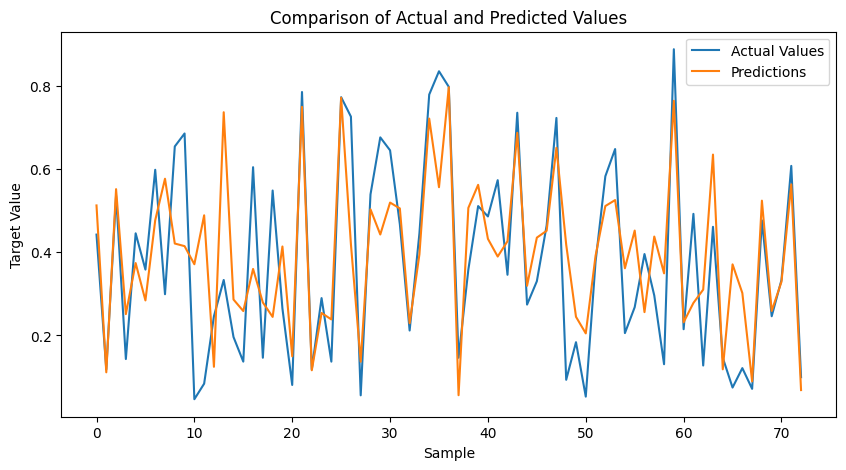

In [23]:


best_model.eval()  # set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():
    val_loss = 0.0
    for features, targets in val_loader:
        preds = best_model(features)
        loss = nn.MSELoss()(preds, targets)
        val_loss += loss.item() * features.size(0)
        predictions.extend(preds.view(-1).tolist())
        actuals.extend(targets.view(-1).tolist())

val_loss /= len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.4f}")

# Convert predictions and actuals to numpy arrays for any further analysis
predictions = np.array(predictions)
actuals = np.array(actuals)

# Optionally, you might want to visualize the predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Target Value')
plt.legend()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32d4ae45-92b1-4635-a0c2-56c132478f05' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>